## Simple example reconstructing the sin function


## Imports and dataset

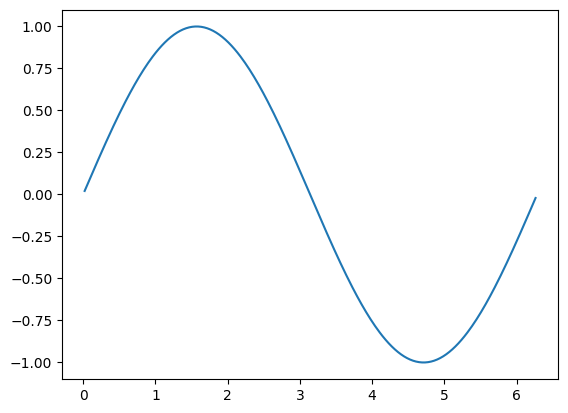

In [14]:
import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import cross_val_score

import numpy as np
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

import sklearn.metrics

import timeit

def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

X = []
Y = []

num_samples = 300

for i in range(1, num_samples):
    X.append(2.0*math.pi/num_samples * float(i))
    Y.append(math.sin(2.0*math.pi/num_samples * float(i)))

plt.plot(X, Y)
plt.show()

X = torch.Tensor(X)
Y = torch.Tensor(Y)

X = X.reshape(-1, 1)

dataset = HPO.Dataset(X, Y)

BUDGET = 2
VERBOSE = 0
CV = 2
SCORING = 'neg_mean_squared_error'
TESTING = False

ITER = 20

BUDGETS = [i*10 for i in range(1, ITER+1)]

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []

GRID_TIME = []
RANDOM_TIME = []
BAYESIAN_TIME = []
SPARSE_TIME = []


## Hyperparameterspace & Model & Function

In [15]:
hyperparameterspace = {
    'loss': ["list", 'binary_crossentropy', 'categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error', 'mean_absolute_error'],
    #'loss': ["list", 'mean_absolute_error', 'log_cosh'],
    'epochs': ["interval-int", 1, 400]
}

##################### Model for grid and random search #####################

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_shape=(1,), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation=None))
    # Compile model
    #model.compile(loss=loss,
    #              optimizer='adam', metrics=['mean_squared_error'])
    return model

##################### Blackbox function for bayesian optimization #####################

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste


def blackboxfunction(params):
    index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
    loss = hyperparameterspace_special["loss"][index]
    
    epochs = int(params[1])

    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        model.add(Dense(10, input_shape=(1,), activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(1, activation=None))
        # Compile model
        model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
        return model

    model = KerasRegressor(model=create_model, verbose=0)

    model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

    if TESTING:
        print("Test set is being used")
        Y_predicted = model.predict(dataset.get_X_test())
        return sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)
    else:
        Y_predicted = model.predict(dataset.get_X_validation())
        return -sklearn.metrics.mean_squared_error(dataset.get_Y_validation(), Y_predicted)
    

##################### Function for sparse grid search #####################

class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(2)


    def eval(self, x):
        index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = hyperparameterspace_special["loss"][index]
        epochs = int(from_standard(1, 400, x[1]))
        
        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(10, input_shape=(1,), activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(1, activation=None))
            # Compile model
            model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        # scores = cross_val_score(model, dataset.get_X(), dataset.get_Y(), cv=CV, scoring=SCORING)

        # return -scores.mean()

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

        if TESTING:
            Y_predicted = model.predict(dataset.get_X_test())
            return sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
        else:
            Y_predicted = model.predict(dataset.get_X_validation())
            return sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
        


## Grid search

In [16]:
BUDGET = 10
for i in range(1, ITER+1):
    BUDGET = 10*i
    model = KerasRegressor(model=create_model, verbose=0)

    optimization = HPO.Optimization(dataset, model, hyperparameterspace, type="grid_search", cv=CV, budget=BUDGET, verbosity=VERBOSE)

    starttime = timeit.default_timer()
    result = optimization.fit()
    endtime = timeit.default_timer()

    # print("Best result:")
    # print(-result.best_score_)
    # print("Corresponding parameters:")
    # print(result.best_params_)

    # Y_predicted = result.predict(torch.Tensor(X).reshape(-1, 1))

    # plt.plot(X,Y_predicted)
    # plt.show()

    Y_predicted = result.predict(dataset.get_X_test())

    GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
    GRID_TIME.append(endtime-starttime)
    

Best result:
0.004729854874312878
Corresponding parameters:
{'epochs': 333, 'loss': 'mean_squared_error'}
Best result:
0.0038237256230786443
Corresponding parameters:
{'epochs': 250, 'loss': 'mean_squared_error'}


## Random search

In [17]:
BUDGET = 10
for i in range(1, ITER+1):
    BUDGET = 10*i

    model = KerasRegressor(model=create_model, loss='binary_crossentropy', verbose=0)
    optimization = HPO.Optimization(dataset, model, hyperparameterspace, type="random_search", cv=CV, budget=BUDGET, verbosity=VERBOSE)

    starttime = timeit.default_timer()
    result = optimization.fit()
    endtime = timeit.default_timer()

    # print("Best result:")
    # print(-result.best_score_)
    # print("Corresponding parameters:")
    # print(result.best_params_)

    # Y_predicted = result.predict(torch.Tensor(X).reshape(-1, 1))

    # plt.plot(X,Y_predicted)
    # plt.show()

    Y_predicted = result.predict(dataset.get_X_test())
    RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
    RANDOM_TIME.append(endtime - starttime)

## Bayesian Optimization 

https://thuijskens.github.io/2016/12/29/bayesian-optimisation/ 

In [ ]:
BUDGET = 10
for i in range(1, ITER+1):
    BUDGET = 10*i

    optimization = HPO.Optimization(dataset, blackboxfunction, hyperparameterspace, type="bayesian", budget=BUDGET, verbosity=VERBOSE)

    starttime = timeit.default_timer()
    result = optimization.fit()
    endtime = timeit.default_timer()

    # fig = plt.figure()
    # ax = plt.axes(projection='3d')

    # x = [result[0][i][0] for i in range(len(result[0]))]
    # y = [result[0][i][1] for i in range(len(result[0]))]

    # ax.plot_trisurf(x, y, result[1])


    index_best = 0
    for i in range(len(result[1])):
        if result[1][i] == max(result[1]):
            index_best = i

    best_score = result[1][index_best]
    best_params = result[0][index_best]


    # print("Best MSE:")
    # print(best_score)
    # print("With Hyperparameters: ")
    # i = 0
    # for key in hyperparameterspace.keys():
    #     if hyperparameterspace[key][0] == "list":
    #         index = int(best_params[i]*(len(hyperparameterspace_special[key])-1))
    #         print(key + ": " + str(hyperparameterspace_special[key][index]))
    #     else:
    #         print(key + ": " + str(best_params[i]))
    #     i += 1


    # print([result[0][i] for i in range(len(result[0])) if result[1][i] == max(result[1])])

    TESTING = True
    BAYESIAN_RESULT.append(blackboxfunction(best_params))
    TESTING = False

    BAYESIAN_TIME.append(endtime - starttime) 

## Sparse grid search

In [ ]:
BUDGET = 10
for i in range(1, ITER+1):
    BUDGET = 10*i

    f = ExampleFunction()

    optimization = HPO.Optimization(dataset, f, hyperparameterspace, type="sparse", budget=BUDGET, verbosity=VERBOSE)

    starttime = timeit.default_timer()
    result = optimization.fit()
    endtime = timeit.default_timer()

    TESTING = True
    SPARSE_RESULT.append(f.eval(result))
    TESTING = False

    SPARSE_TIME.append(endtime - starttime)


## Comparison of the methods

In [ ]:
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# opts = ['Grid search', 'Random search', 'Bayesian Optimization', 'Sparse grid search']
# results = [GRID_RESULT, RANDOM_RESULT, BAYESIAN_RESULT, SPARSE_RESULT]
# ax.bar(opts, results)
# ax.set_ylabel("Mean squared error")
# plt.show()

In [ ]:
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# opts = ['Grid search', 'Random search', 'Bayesian Optimization', 'Sparse grid search']
# results = [GRID_TIME, RANDOM_TIME, BAYESIAN_TIME, SPARSE_TIME]
# ax.bar(opts, results)
# ax.set_ylabel("Time")
# plt.show()

In [ ]:
plt.plot(BUDGETS, GRID_RESULT, label = "Grid search")
plt.plot(BUDGETS, RANDOM_RESULT, label = "Random search")
plt.plot(BUDGETS, BAYESIAN_RESULT, label = "Bayesian Optimization")
plt.plot(BUDGETS, SPARSE_RESULT, label = "Sparse grid search")

plt.xlabel('Budget')
plt.ylabel('Mean squared error')

plt.title('Result depending on budget')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

In [ ]:
plt.plot(BUDGETS, GRID_TIME, label = "Grid search")
plt.plot(BUDGETS, RANDOM_TIME, label = "Random search")
plt.plot(BUDGETS, BAYESIAN_TIME, label = "Bayesian Optimization")
plt.plot(BUDGETS, SPARSE_TIME, label = "Sparse grid search")

plt.xlabel('Budget')
plt.ylabel('Time in sec')

plt.title('Time depending on budget')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()